# Review of Pathfinding Algorithms in the Minihack Environment
### DaisyHack Team for the Artificial Intelligence Fundamental Course, 2023/2024
Cosimo Botticelli, Maria Colella, Michele Mattiello, Nazifa Mosharrat, Roberto Della Rocca

---

### Setting up the environment
Assuming we are in a proper virtual environment, we can setup the environment and import the adequate packages using the following block of code.

In [71]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import sys
import random
import copy
from datetime import datetime
from tqdm import tqdm

from collections import deque
from queue import PriorityQueue
from utilsMinihackSearch import *
from typing import Tuple, List

---

## Hill Climbing Search

For our first search algorithm, we expect a simple and greedy behaviour that can quickly cover large distances but gets stuck at the fist local minimum.

In [ ]:
# Function to perform hill climbing algorithm to find a path from start to target
def hill_climb(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    # Initialize the current state with the start position
    current = {'state': start}
    # Initialize the parent dictionary to track paths
    parent = {start: None}  
    # Continue the loop until a solution is found or an appropriate condition is met
    while True:
        # Find the highest valued successor based on the heuristic
        neighbor = highest_valued_successors(current, game_map, target, h)
        # Check if the heuristic value of the neighbor is less than or equal to the current state
        if h(neighbor['state'], target) >= h(current['state'], target):
            # If true, construct and return the path
            path = build_path_HillClimb(parent, start, target)
            return path
        
        # Update the parent dictionary with the current and neighbor states
        parent[neighbor['state']] = current['state']
        # Move to the neighbor state for the next iteration
        current = neighbor
        
        # Debugging statements
        # print("Parent dictionary:", parent)  
        # print("Target:", target)
        # print("Current state:", current['state'])

# Function to build the path from the parent dictionary
def build_path_HillClimb(parent: dict, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    current = target
    
    # Continue until reaching the start or a dead end
    while current is not None and current != start:
        # Append the current state to the path
        path.append(current)
        # Check if the current state is not in the parent dictionary
        if current not in parent:
            print(f"Target {target} not reachable from start {start}.")
            return None
        # Move to the parent state for backtracking
        current = parent[current]
    
    # Add the starting point to the path and reverse the order
    path.append(start)
    path.reverse()
    
    return path

# Function to find the highest valued successor based on the heuristic
def highest_valued_successors(node, game_map, target, h):
    # Get valid moves (successors) from the current state
    successors = get_valid_moves(game_map, node['state'])
    # Sort successors based on the heuristic value in descending order
    successors.sort(key=lambda x: h(x, target), reverse=True)
    successors.reverse()
    # Return the highest valued successor
    return {'state': successors[0]}

env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/empty.des",
)
state = env.reset()

#### Empty map
A first simple map is useful to show how the algorithm behaves in a very smooth solution space, with no local minima.

In [ ]:
plt.imshow(state['pixel'][70:300, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

The path to the exit is computed and stored, if it does exist.

In [ ]:
path = hill_climb(game_map, start, target, manhattan_distance)
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

#### Map with a single local minima
This map shows the limits of a greedy algorithm; it gets stuck on the very first local minima despite there being a valid solution (multiple solutions, in fact).

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/one_local_minimum.des",
)
state = env.reset()
plt.imshow(state['pixel'][70:300, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
path = hill_climb(game_map, start, target, manhattan_distance)
if path is not None:
    actions = actions_from_path(start, path[1:])
    image = plt.imshow(game)
    for action in actions:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        image.set_data(s['pixel'][70:300, 500:730])

---

## Hill Climbing Search with Backtracking

A variation of our first algorithm goes to show how a little addition can go a long way.

We add backtracking in order to get out of local minima.

In [ ]:
def build_path_HillClimb(parent: dict, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    current = target

    while current is not None and current != start:
        path.append(current)
        current = parent[current]

    path.append(start)  # Add the starting point to the path
    path.reverse()

    return path

def hill_climb(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    # initialize open and close list
    open_list = [start]
    close_list = []
    parent = {start: None}

    while open_list:
        # getting the current node
        current = open_list.pop()
        # adding the node to the close list
        close_list.append(current)

        if current == target:
            path = build_path_HillClimb(parent, start,target)
            return path

        for neighbor in get_valid_moves(game_map, current):
            # check if neighbor in close list, if so continue
            if neighbor in close_list:
                continue

            # compute neighbor h value
            neighbor_h = h(neighbor, target)
            parent[neighbor] = current
            # if neighbor not in open list, adding it
            if neighbor not in open_list:
                open_list.append(neighbor)

    return None

####  Map with a single local minimum
This map has a single local minimum; with a little backtracking we can handle this easily and in fact the character goes around the critical area and gets to the goal.

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/one_local_minimum.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]

start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
for i in range(1):
    path = hill_climb(game_map, start, target, manhattan_distance)
    if path is not None:
        print("Path found!")
    else:
        print("Path not found!")

In [ ]:
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

####  A map with multiple local minima

This map with several local minima tests the limit of this algorithm.

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/many_local_minima.des",
)
state = env.reset()

plt.imshow(state['pixel'][100:285, 500:765])

In [ ]:
game_map = state['chars']
game = state['pixel'][100:285, 500:765]

start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
for i in range(1):
    path = hill_climb(game_map, start, target, manhattan_distance)
    if path is not None:
        print("Path found!")
    else:
        print("Path not found!")

In [ ]:
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][100:285, 500:765])

^ this should fail but doesn't

---

## Local Beam Search

With this algorithm we trade off some memory for better exploration capabilities.

The *k* best states are kept in memory and exploder when the current path being explored fails to reach the goal.

This algorithm could be complete for maps of any size with the allocation of infinite memory, in theory.

In practice, it's up to us to choose the best amount of memory to allocate.

##### Stochasticity

Furthermore, the direction chosem by this algorithm is sometimes left up to chance. This lets us explore more thoroughly the solution space, but one execution of the algorithm is not enough to determine its efficiency.

Thus, in the next few examples, we will run the algorithm 1000 times for each map.

In [ ]:
import random
import time


def initialize_states(game_map: np.ndarray, start: Tuple[int, int], k: int):

    init_states = [list(random.choice(get_valid_moves(game_map, start))) for _ in range(k)]
    
    current_states = []
    for state in init_states:
        current_states.append({
            'current': tuple(state),
            'explored_nodes': [tuple(state)],
            'path': [tuple(state)]
        })

    return current_states

def get_successors_from_states(game_map: np.ndarray, states: list):

    state_neighbors = []

    for state in states:
        neighbors = get_valid_moves(game_map, state['current'])
        state_neighbors.append({
            'path': state['path'],
            'explored_nodes': state['explored_nodes'],
            'possible_moves': neighbors
        })
        

    return state_neighbors

def get_heuristic_scores(heuristic: callable, neighbors: list):

    scored_moves = []

    for state in neighbors:
        for move in state['possible_moves']:
            score_target = heuristic(move, target)
            score_start = heuristic(start, move)
            scored_moves.append({
                'path': state['path'],
                'explored_nodes': state['explored_nodes'],
                'current': move,
                'distance_from_target': score_target,
                'distance_from_start': score_start
            })
    
    return scored_moves

def assign_probabilities(sorted_array):
    n = len(sorted_array)
    probabilities = [1 / (i + 1) for i in range(n)]
    
    # give the same probability if two elements has the same distance
    for i in range(1, n):
        if sorted_array[i] == sorted_array[i - 1]:
            probabilities[i] = probabilities[i - 1]
    
    return probabilities

def get_next_states(scored_successors: list, k: int, stocastic: bool):

    scored_successors_from_target = sorted(scored_successors, key = lambda x: x['distance_from_target'])
    scored_successors_from_start = sorted(scored_successors, key = lambda x: x['distance_from_start'], reverse=True)
    scored_successors = None

    if scored_successors_from_start[0]['distance_from_start'] - 15 < scored_successors_from_target[0]['distance_from_target'] :
        scored_successors = scored_successors_from_start
    else:
        scored_successors = scored_successors_from_target

    # scored_successors = scored_successors_from_start

    top = []

    if stocastic:
        cont = 0
        while cont < k:
            # top.append(scored_successors[random.randrange(0, len(scored_successors))])
            probability_array = assign_probabilities(scored_successors)
            choice = random.choices(scored_successors, probability_array)[0]
            if choice not in top:
                top.append(choice)
                cont += 1
    else:
        cont = 0
        for succ in scored_successors:
            if cont < k:
                if succ['current'] not in succ['explored_nodes']:
                    succ['explored_nodes'] = succ['explored_nodes'] + [succ['current']]
                    top.append(succ)
                    cont += 1

                
    
    next_states = list()
    
    for s in top:
        next_states.append({
            'current': s['current'],
            'explored_nodes': s['explored_nodes'],
            'path': s['path'] + [s['current']]
        })
    
    return next_states


def local_beam_search(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], heuristic: callable, k: int = 3, max_iter: int = 100, stocastic: bool = False):

    current_states = initialize_states(game_map, start, k)

    for i in range(max_iter):

        state_neighbors = get_successors_from_states(game_map, current_states)

        if len(current_states) == 0 or i == max_iter - 1:
            path = [start] + backup_states[0]['path'] + [move]
            return None
        
        # check if a possible move is the target
        for state in state_neighbors:
            for move in state['possible_moves']:
                if move == target:
                   path = [start] + state['path'] + [move]
                   return path

        scored_successors = get_heuristic_scores(heuristic, state_neighbors)
        backup_states = current_states
        current_states = get_next_states(scored_successors, k, stocastic)

#### Map with two local minima
A map with two local minima, easy to manage for a beam search algorithm.

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/two_local_minima.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
founded = 0
finalPath = None
for i in range(1000):
    path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if path:
        founded += 1
        finalPath = path

print(f"{founded}/1000 correct paths.")

In [ ]:
actions = actions_from_path(start, path[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

#### Medium difficulty maze
A maze with multiple local minima, but still manageable for the Local Beam Search.

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/medium_diff_maze.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
correct_paths = 0
finalPath = None
for i in range(1000):
    path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if path is not None:
        correct_paths += 1
        finalPath = path

print(f"{correct_paths}/1000 correct paths.")

In [ ]:
actions = actions_from_path(start, finalPath[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

#### Failure state map
This is an example of a maze that can't be solved by the algorithm.

We can see the player trying to get far away from the starting point and then getting stuck irreversably in a local minima.

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/hard_maze.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
correct_paths = 0
finalPath = None
for i in range(1000):
    path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=10000)
    if path is not None:
        correct_paths += 1
        finalPath = path

if correct_paths == 0:
    print("No path to the exit has been found.")
else:
    print(f"{correct_paths}/1000 correct paths.")

---

## Genetic Algorithm

A custom genetic algorithm that can build path through evolutive concepts such as selection of best specimens in order to get better and better solutions, and mutation in order to explore good but unpromising paths.

In [72]:
'''INITIALIZATION'''
def inizialize_gene(env: gym.Env, gene_length: int, get_available_actions: callable) -> [int]:
    gene = []
    state = env.reset()
    for _ in range(gene_length):
        game_map = state['chars']
        moves = get_available_actions(game_map)
        move = random.randint(0, len(moves) - 1)
        env.step(moves[move])
        gene.append(moves[move])
    return gene

def initialize_population(env: gym.Env,n_genes: int, gene_length: int, get_available_actions: callable, prefix = []) -> [[int]]:
    population = []
    for _ in range(n_genes):
        gene = inizialize_gene(env, gene_length, get_available_actions)
        population.append(prefix + gene)
    return population

In [73]:
'''SELECTION'''
def rouletteWheelSelection(population: [[]], heuristic_results: [float], length_new_population: int = None):
    new_population = []
    total = sum(heuristic_results)
    propabilities = [value/total for value in heuristic_results]
    length = length_new_population if length_new_population != None else len(population)
    for _ in range(length):
        index = np.random.choice(len(population), p=propabilities)
        new_population.append(population[index])
    return new_population

In [74]:
'''CROSSOVER'''
def singlePointCrossover(population: [[]]):
    if(len(population)<1):
        raise ValueError()
    point = round(len(population[0]) / 2)
    length =  len(population) - 1 if len(population) % 2 != 0 else len(population) 
    for i in range(0, length, 2):
        firstGene = population[i]
        secondGene = population[i+1]
        newFirstGene = firstGene[:point] + secondGene[point:]
        newSecondGene = secondGene[:point] + firstGene[point:]
        population[i] = newFirstGene
        population[i+1] = newSecondGene
    return population
 
def orderCrossover(population: [[]], shuffle_size=5):
    #shuffle_size = shuffle_size #round(len(population[0]) / 2)
    length =  len(population) - 1 if len(population) % 2 != 0 else len(population)
    for i in range(0, length, 2):
        firstGene = population[i]
        secondGene = population[i+1]
        # create list from 0 to size
        index = [*range(len(firstGene))] 
        # randomly select shuffle_size elements from index list
        bit_mask = set(random.sample(index, shuffle_size))
        inverse_bit_mask = set(index) - bit_mask

        newFirstGene = copy.deepcopy(firstGene)
        newSecondGene = copy.deepcopy(secondGene)


        for j in bit_mask:
            newFirstGene[j] = secondGene[j]
        for j in inverse_bit_mask:
            newSecondGene[j] = firstGene[j]

        for j, k in zip(inverse_bit_mask, bit_mask):
            newFirstGene[j] = firstGene[k]
        for j, k in zip(inverse_bit_mask, bit_mask):
            newSecondGene[k] = secondGene[j]


        population[i] = newFirstGene
        population[i+1] = newSecondGene
    return population

In [75]:
'''MUTATION'''
def displacementMutation(population: [[]], substring_length):
    if len(population) < 1:
        raise ValueError()
    length = len(population[0]) - substring_length
    first_index = random.randint(0, length)
    second_index = random.randint(0, length)
    for i in range(len(population)):
        gene = population[i]
        substring = gene[first_index : first_index + substring_length]
        gene[first_index : first_index + substring_length] = gene[second_index : second_index + substring_length]
        gene[second_index : second_index + substring_length] = substring
        population[i] = gene
    return population

In [76]:
'''HEURISTICS'''
def heuristic1(env, path):
    '''heuristic based on distance between current player position and initial player position'''
    state = env.reset()
    game_map = state['chars']
    init_player_location = get_player_location(game_map)
    for move in path:
        state, _, done, _ = env.step(move)
        if done:
            return 10001
        game_map = state['chars']
    player_location = get_player_location(game_map)
    return  round(manhattan_distance(player_location, init_player_location), 2)

def heuristic2(env, path):
    '''heuristic based on distance between current player position and target position.'''
    extra_points = 0
    points = 0
    state = env.reset()
    game_map = state['chars']
    target_location = get_target_location(game_map)
    for move in path:
        state, _, done, _ = env.step(move)
        if done:
            return 10001
        player_location = get_player_location(game_map)
        if manhattan_distance(player_location, target_location) < 25:
            extra_points = round(1000 / manhattan_distance(player_location, target_location), 2)
        game_map = state['chars']
    player_location = get_player_location(game_map)
    points = round(100 / manhattan_distance(player_location, target_location), 2)
    return points + extra_points

def h(val: bool):
    '''combine heuristic1 and heuristic2'''
    return lambda env, path: heuristic1(env, path) + heuristic2(env, path) if val == True else heuristic2(env, path)

In [77]:
'''LOGGING'''
class Logger:
    def __init__(self, filename = f"./logs/{datetime.now().isoformat()}"):
        if filename is not None:
            self.filename = filename
            f = open(filename, "w")
            f.close()

    def debug(self, message, end="\n"):
        f = open(self.filename, "a")
        f.write(message + end)
        f.close()

In [78]:
'''CORE OPERETORS'''
logger = Logger()
def core(epochs, paths, substring_length, env, length_new_population = None, heuristic: callable = heuristic1, shuffle_size=5, prefix = []):
    heuristic_results = [1]*len(paths)
    best_path = []
    best_points = 0
    for i in tqdm(range(epochs)):
        paths = rouletteWheelSelection(paths, heuristic_results, length_new_population)
        paths = singlePointCrossover(paths)
        paths = orderCrossover(paths, shuffle_size)
        paths = displacementMutation(paths, substring_length)
        heuristic_results = []
        for j in range(len(paths)):
            points = heuristic(env, prefix + paths[j])
            if points > best_points:
                best_points = points
                best_path = paths[j]
            heuristic_results.append(round(points, 2))
        logger.debug(f"{i+1} generation: ", end="")
        logger.debug(f"{heuristic_results}")
    logger.debug(f"\nend generation (best genes): {best_points}\n")
    return paths, best_path

In [79]:
'''GENETIC ALGORITHM'''
def get_available_actions(game_map):
    player_location = get_player_location(game_map)
    available_moves = get_valid_moves(game_map, player_location)
    available_actions = [actions_from_path(player_location, [move])[0] for move in available_moves]
    return available_actions

def ga(env_opts, ga_opts, exe_opts, queue=None):
    env = gym.make(
        env_opts["id"],
        observation_keys=env_opts["observation_keys"],
        des_file = env_opts["des_file"],
    )

    unit = exe_opts["unit"]
    rate = exe_opts["rate"]
    epochs_unit = round(exe_opts["epochs"]/unit)
    path_unit = round(ga_opts["path_length"]/unit)
    mutation_unit = round(ga_opts["substring_length"]/unit)
    shuffle_unit = round(ga_opts["shuffle_size"]/unit)
    prefix = []

    for i in range(unit):
        paths = initialize_population(env, ga_opts["n_genes"], path_unit, get_available_actions)
        paths, best_path = core(epochs_unit, paths, mutation_unit, env, heuristic=h(i < rate), shuffle_size=shuffle_unit, prefix=prefix)
        if i < unit - 1:
            prefix += best_path

    if queue:
        for path in paths:
            queue.put(prefix + path)
        queue.put(prefix + best_path)
    else:
        paths = [prefix + path for path in paths]
        paths.append(prefix + best_path)
        return paths

#### Difficult maze
A difficult problem to demonstrate the flexibility a custom genetic algorithm can achieve.

The tradeoff is the extended execution time, which is several orders of magnitude greater than the other algorithms here implemented.

In [80]:
'''LOAD ENVIRONMENT VARIABLES'''
env_opts = {
    "id": "MiniHack-Navigation-Custom-v0",
    "des_file": "./mazes/hard_maze.des",
    "observation_keys": ("chars", "pixel"),
}
ga_opts = {
    "n_genes": 4,
    "path_length": 95,
    #mutation parameters
    "substring_length": 23,
    #crossover parameters
    "shuffle_size": 35,
}
exe_opts = {
    "epochs": 10,
    "unit": 5,
    "rate": 3
}

In [81]:
'''EXECUTION'''
best_path = []
best_score = 0

paths = ga(env_opts, ga_opts, exe_opts)

env = gym.make(
        env_opts["id"],
        observation_keys=env_opts["observation_keys"],
        des_file = env_opts["des_file"],
    )

for path in paths:
    state = env.reset()
    game_map = state['chars']
    game = state['pixel'][70:300, 500:730]
    start = get_player_location(game_map)
    target = get_target_location(game_map)
    h = heuristic2(env, path)
    if h > best_score:
        best_path = path
        best_score = h

100%|██████████| 1/1 [00:12<00:00, 12.53s/it]


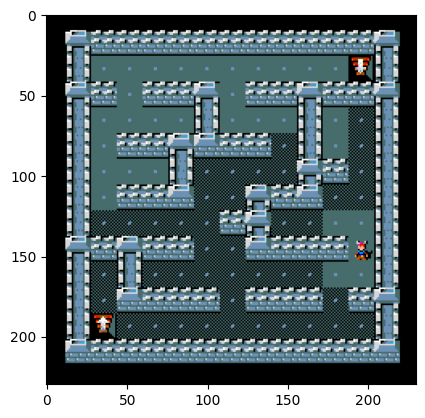

In [82]:
def display_game(image, path):
    try:
        for move in path:
            s, _, _, _ = env.step(move)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            image.set_data(s['pixel'][70:300, 500:730])
    except:
        return
    
path = best_path
state = env.reset()
game_map = state['chars']
game = state['pixel']
image = plt.imshow(game[70:300, 500:730])
points = display_game(image, path)

---

## Simulated Annealing

With this algorithm we exploit a lot of randomness during the first steps in order to explore the solution space thoroughly, and to get out of local optima.

Moving forward, the temperature lowers, and the chanche of taking sub-optimal steps lowers with it.

The algorithm eventually converges to always chosing the optimal step, akin to an Hill Climbing search, and has a maximum number of steps as termination condition, if it still can't find the exit.

In [104]:
def exp_schedule(t: int):
    """One possible schedule function for simulated annealing"""
    return t * 0.95

def assign_probabilities(sorted_array, deltas, t):
    n = len(sorted_array)
    if t < 0.01:
        probabilities = [1] + [0] * (n - 1)
    else:
        probabilities = [math.exp(-deltas[i] / t) for i in range(n)]
    return probabilities

def ordered_successors(node, game_map, target, h):
    successors = get_valid_moves(game_map, node['state'])
    successors.sort(key=lambda x: h(x, target), reverse=True)
    successors.reverse()
    return successors

def calcolo_delta(neighbors, current, h, target):
    deltas = []
    n = len(neighbors)
    current_hValue = h(current['state'], target)
    for i in range(n):
        x = h(neighbors[i], target)
        deltas.append(x - current_hValue)
    return deltas

def simulated_annealing(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable, T: int, annealing: float) -> List[Tuple[int, int]]:
    path = []
    current = {'state': start}
    startt = {'state': start}
    path.append(start)
    while True: 
        if T > 0:
            T = exp_schedule(T)
        neighbors = ordered_successors(current, game_map, target, h)
        deltas = calcolo_delta(neighbors, startt, h, target)
        probabilities = assign_probabilities(neighbors, deltas, T)
        # print(f"deltas: {deltas},   prob: {probabilities}, T: {T}")
        choice = random.choices(neighbors, probabilities)[0]
        path.append(choice)
        current = {'state': choice}
        # print(f"choice: {current}")
        if current['state'] == target:
            return path, True
        if len(path) == 150:
            return path, False

#### Empty map
Such a map is easily solvable by a simulated annealing search, since the algorithm eventually behaves like a hill climbing search, which as we have already seen, can solve an empty map quite easily.

It's still useful to observe this case since it shows very well how the algorithm behaves quite chaotically in the beginning and then starts to converge towards a greedy behaviour.

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/empty.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

We call the algorithm with an `annealing` value of 0.92, meaning the temperature will drop by 8% of its current value of each step. This is quite a big drop in temperature, but fitting to the map at hand.

In [ ]:
found = 0
finalPath = None
numIter = 1
for i in range(numIter):
    path, isPathFound = simulated_annealing(game_map, start, target, manhattan_distance, 100, annealing = 0.92)
    if isPathFound:
        found += 1
        finalPath = path

print(f"{found}/{numIter} correct paths.")

In [ ]:
print(f"st: {start}, pat: {finalPath}")
actions = actions_from_path(start, finalPath[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

#### Hard maze
This is a maze that can't be solved 100% of the time, so we execute the algorithm multiple times and with different values for `annealing`; in particular, the algorithm is ran 10 times for each value of `annealing` ranging from 0.899 to 0.999, with an increment step of 0.001, for a total of 1000 executions.

The solution with the smallest amount of steps is then memorized and shown.

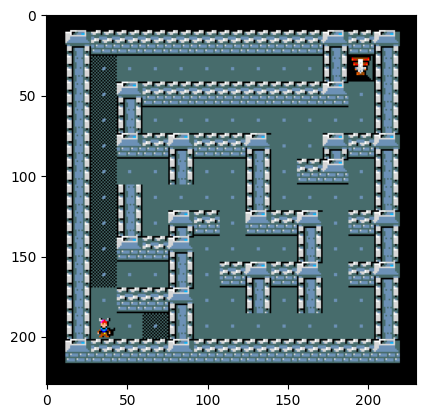

In [115]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/hard_maze.des",
)
state = env.reset()

plt.imshow(state['pixel'][70:300, 500:730])

In [116]:
game_map = state['chars']
game = state['pixel'][70:300, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (16, 33)
Target position: (6, 43)


In [124]:
found = 0
finalPath = None
numIter = 10000
dynamicAnnealing = 0.899
for i in range(100):
    dynamicAnnealing = dynamicAnnealing + 0.001
    for j in range(100):
        path, isPathFound = simulated_annealing(game_map, start, target, manhattan_distance, 100, annealing = dynamicAnnealing)
        if isPathFound:
            found += 1
            if(found == 1):
                finalPath = path
            if len(path) < len(finalPath):
                finalPath = path

print(f"{found}/{numIter} correct paths.")

1/10000 correct paths.


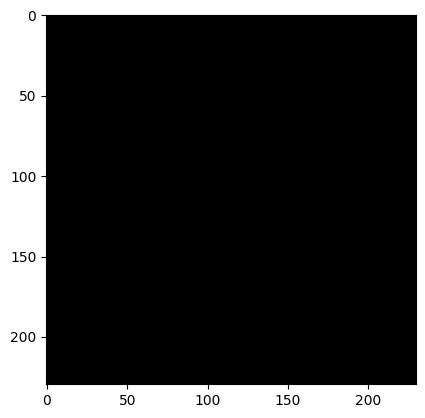

In [125]:
print(f"st: {start}, pat: {finalPath}")
actions = actions_from_path(start, finalPath[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][70:300, 500:730])

#### Maze which is artificially full of local minima
This maze is comprised of a lot of local minima. Even then, we aim to show that simulated annealing can squeeze its way through the correct path, diven enough iterations and variations in the `annealing` variable.

In [ ]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "mazes/many_local_minima.des",
)
state = env.reset()

plt.imshow(state['pixel'][100:265, 500:730])

In [ ]:
game_map = state['chars']
game = state['pixel'][100:265, 500:730]
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

In [ ]:
found = 0
finalPath = None
numIter = 2500
dynamicAnnealing = 0.899
for i in range(100):
    dynamicAnnealing = dynamicAnnealing + 0.001
    for j in range(25):
        path, isPathFound = simulated_annealing(game_map, start, target, manhattan_distance, 100, annealing = dynamicAnnealing)
        if isPathFound:
            found += 1
            if(found == 1):
                finalPath = path
            if len(path) < len(finalPath):
                finalPath = path

print(f"{found}/{numIter} correct paths.")

In [ ]:
print(f"st: {start}, pat: {finalPath}")
actions = actions_from_path(start, finalPath[1:])
image = plt.imshow(game)
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'][100:265, 500:730])

# Systematic comparison of the implemented algorithms